In [6]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib

import helper_functions.utils
import helper_functions.flood_utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.flood_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.flood_utils as flood_utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.publicTransit as publicTransit

# Import bus network

In [2]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

### Import planning area

<Axes: >

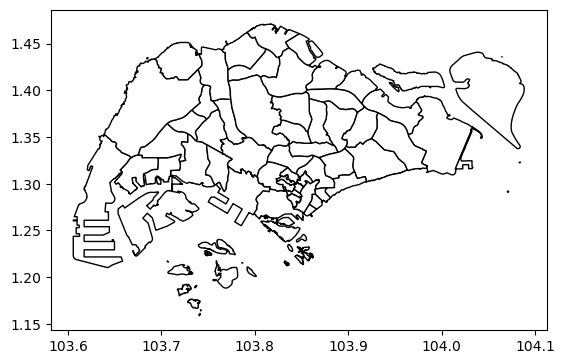

In [3]:
planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019_PlanningArea_Fixed.shp")
planningArea_shp.plot(fc='white',ec='k')

### Import work cluster

In [19]:
workplace_cluster = pd.read_csv(r"data\workplace_cluster.csv")
workplace_cluster
workplace_nodes = ox.distance.nearest_nodes(G_bus, X=workplace_cluster.longitude.to_list(), Y=workplace_cluster.latitude.to_list())
workplace_nodes
workplace_cluster['node_ID'] = workplace_nodes
workplace_cluster.head()

,latitude,longitude,node_ID
0,1.320935,103.894151,258305981
1,1.327584,103.703464,4494048581
2,1.448092,103.810287,4607055587
3,1.284441,103.842959,246800416
4,1.295068,103.629310,842360753


# Import public transit json routes

In [20]:
publicTransit_dir = r"D:\PAKHUIYING\publicTransit_busRouting_busLeg_OneMap"
publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir) if not fp.endswith('_ERROR.json')]
print(len(publicTransit_fp_list))
publicTransit_fp_list[:10]

62881


['D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to243998823.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to246800416.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to310231673.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4229611568.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4602456624.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4602603057.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting_busLeg_OneMap\\01012to6247137952.json']

In [21]:
# import one itinerary
itinerary = utils.load_json(publicTransit_fp_list[1])
itinerary

{'busStart': [1.29684825487647, 103.85253591654006, '01012'],
 'workEnd': [1.284440837350969, 103.84295929434434, 246800416],
 'duration': 797,
 'startTime': 1738713644000,
 'endTime': 1738714441000,
 'transitTime': 468,
 'waitingTime': 0,
 'transfers': 0,
 'busLegs': [{'leg_number': 0,
   'duration': 468,
   'distance': 1961.54,
   'startTime': 1738713737000,
   'endTime': 1738714205000,
   'tripId': '2-1-1002',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '2',
   'legGeometry': {'points': 'wi|FswzxRFB`@ZDDJHbDpCrCfCDDn@h@?????@@@vAnAxAn@TJlAh@|Ap@JD\\LJB????@@B@f@PND~DvAVJZJl@TJD\\Nd@TXL????@?@@B@`An@JF^HpCxBx@l@B@????d@^ZT~B~ATRh@`@~@t@tAhAHF@???dA|@pAfA|BdBHF??DB~AnAl@j@d@`@tAdAvAfAhA|@f@`@',
    'length': 71},
   'busLeg': [{'name': 'BRAS BASAH CPLX',
     'stopId': 'FERRY:01019',
     'stopCode': '01019',
     'lon': 103.853022,
     'lat': 1.2969895,
     'arrival': 1738713737000,
     'departure': 1738713737000,
     'stopIndex': 57,
     'stopSequence': 58,
     'ver

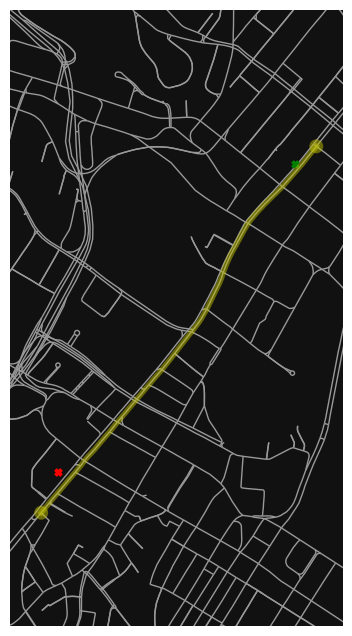

In [61]:
TI = publicTransit.TripItinerary(G_bus, itinerary)
TI.plot_itinerary()

In [62]:
TI = publicTransit.TripItinerary.from_file(G_bus, fp=publicTransit_fp_list[1])
itinerary_entry = TI.get_itinerary_entry()
itinerary_entry

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.284440837350969,
 'end_lon': 103.84295929434434,
 'actual_bus_duration': 468.0,
 'simulated_bus_duration': 123,
 'actual_bus_distance': 1961.54,
 'simulated_bus_distance': 2065,
 'actual_total_duration': 797.0,
 'simulated_total_duration': 452.0,
 'non_bus_duration': 329.0,
 'number_of_busroutes': 1}

In [ ]:
noData_file = os.path.join(r'data','error_itineraryEntry_log1.txt')
itinerary_entries = []
for fp in publicTransit_fp_list:
    TI = publicTransit.TripItinerary.from_file(G_bus, fp=fp)
    try:
        itinerary_entry = TI.get_itinerary_entry()
        itinerary_entries.append(itinerary_entry)
    except:
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{fp}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{fp}\n')

itinerary_df = pd.DataFrame.from_records(itinerary_entries)
# append notes ID to the start and end coordinates
itinerary_df['start_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['start_lon'], Y = itinerary_df['start_lat'])
itinerary_df['end_nodesID'] = ox.distance.nearest_nodes(G_bus,X = itinerary_df['end_lon'], Y = itinerary_df['end_lat'])
# itinerary_df.to_csv(os.path.join(r"data","bus_routing_OneMap.csv"),index=False)
itinerary_df.head()

,start_lat,start_lon,end_lat,end_lon,actual_bus_duration,simulated_bus_duration,actual_bus_distance,simulated_bus_distance,actual_total_duration,simulated_total_duration,non_bus_duration,number_of_busroutes,start_nodesID,end_nodesID
0,1.296848,103.852536,1.415385,103.751913,1037.0,321,4800.10,5366,4336.0,3620.0,3299.0,2,4748705954,243998823
1,1.296848,103.852536,1.284441,103.842959,468.0,123,1961.54,2065,797.0,452.0,329.0,1,4748705954,246800416
2,1.296848,103.852536,1.320935,103.894151,87.0,52,624.40,871,1297.0,1262.0,1210.0,1,4748705954,258305981
3,1.296848,103.852536,1.320213,103.656895,87.0,52,624.40,871,3530.0,3495.0,3443.0,1,4748705954,310231673
4,1.296848,103.852536,1.299561,103.798223,87.0,52,624.40,871,1806.0,1771.0,1719.0,1,4748705954,4229611568


Split itinerary based on unique end nodes e.g. end_nodesID

In [64]:
itinerary_master_df = pd.read_csv(os.path.join(r"data","bus_routing_OneMap.csv"))
print(len(set(itinerary_master_df['end_nodesID'])))
print(itinerary_master_df.dtypes)
itinerary_df_list = {k:df for k,df in itinerary_master_df.groupby('end_nodesID')}
print(len(list(itinerary_df_list)))

12
start_lat                   float64
start_lon                   float64
end_lat                     float64
end_lon                     float64
actual_bus_duration         float64
simulated_bus_duration        int64
actual_bus_distance         float64
simulated_bus_distance        int64
actual_total_duration       float64
simulated_total_duration    float64
non_bus_duration            float64
number_of_busroutes           int64
start_nodesID                 int64
end_nodesID                   int64
dtype: object
12


In [65]:
# check if there are workplace nodes not in itinerary df
print(set(list(itinerary_df_list))^set(workplace_cluster['node_ID']))
workplace_cluster.dtypes

set()


latitude     float64
longitude    float64
node_ID        int64
dtype: object

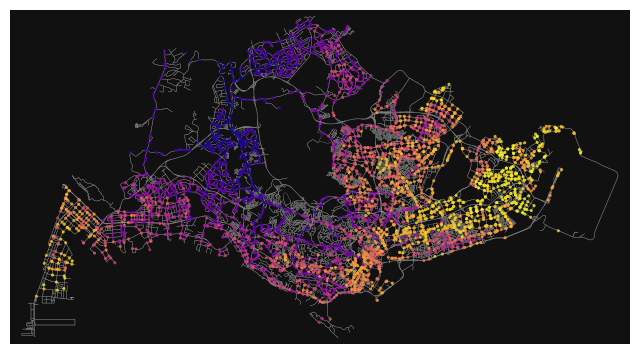

In [ ]:
def plot_shortest_path_publicTransit(G, itinerary_df,ax=None,
                                cmap="plasma",cbar=None,node_size=5):
    """ 
    plot the isochrone using the simulated total duration
    Args:
        G (MultiDiGraph): graph of car network
        itinerary_df (pd.DataFrame): df with columns that describes the simulated or actual time
        cmap (str): cmap for colouring the isochrones
        cbar (ScalarMappable or None): if None, use cmap to automatically generate unique colours based on number of nodes. Else, use cbar to map values to colours
        node_size (float): size of notes for plotting
    Returns:
         
    """
    # create a dict where key are start_nodesID, and values are route times
    route_times = itinerary_df[['start_nodesID','simulated_total_duration']].set_index('start_nodesID').to_dict()
    route_times = route_times['simulated_total_duration']
    # sort dict based on the value i.e. route times
    route_times = {k: v for k, v in sorted(route_times.items(), key=lambda item: item[1])}
    # route_times = itinerary_df['simulated_total_duration'].sort_values()
    if cbar is None:
        iso_colors = ox.plot.get_colors(n=len(route_times), cmap=cmap, start=0)
    else:
        iso_colors = [mpl.colors.rgb2hex(cbar.to_rgba(i),keep_alpha=True) for i in route_times.values()]
    node_colors = {node: nc_ for node, nc_ in zip(list(route_times),iso_colors)}
    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes() ]
    ns = [node_size if node in node_colors else 0 for node in G.nodes()]
    fig, ax = ox.plot_graph(
        G,
        ax=ax,
        node_color=nc,
        node_size=ns,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
        show = False,
        close = False
    )
    return route_times

route_times = plot_shortest_path_publicTransit(G_bus, itinerary_df_list[list(itinerary_df_list)[0]])

In [67]:
itinerary_master_df[itinerary_master_df['number_of_busroutes']>0].sort_values('simulated_total_duration').tail()

,start_lat,start_lon,end_lat,end_lon,actual_bus_duration,simulated_bus_duration,actual_bus_distance,simulated_bus_distance,actual_total_duration,simulated_total_duration,non_bus_duration,number_of_busroutes,start_nodesID,end_nodesID
29533,1.466084,103.808619,1.295068,103.62931,5118.0,2222,24433.00,35091,12141.0,9245.0,7023.0,2,905193731,842360753
47437,1.410769,103.861795,1.295068,103.62931,2744.0,975,14805.71,15213,11054.0,9285.0,8310.0,2,5184268821,842360753
47509,1.402289,103.859630,1.295068,103.62931,2744.0,975,14805.71,15213,11055.0,9286.0,8311.0,2,1781710564,842360753
47497,1.403739,103.858254,1.295068,103.62931,2708.0,1056,16223.29,16648,10989.0,9337.0,8281.0,2,6799293231,842360753
47485,1.404070,103.858281,1.295068,103.62931,2708.0,1056,16223.29,16648,10998.0,9346.0,8290.0,2,6799293231,842360753


# Plot itineraries 
- Only itineraries with at least 1 bus route is plotted
- Each subplot represents itinerary to a unique work cluster

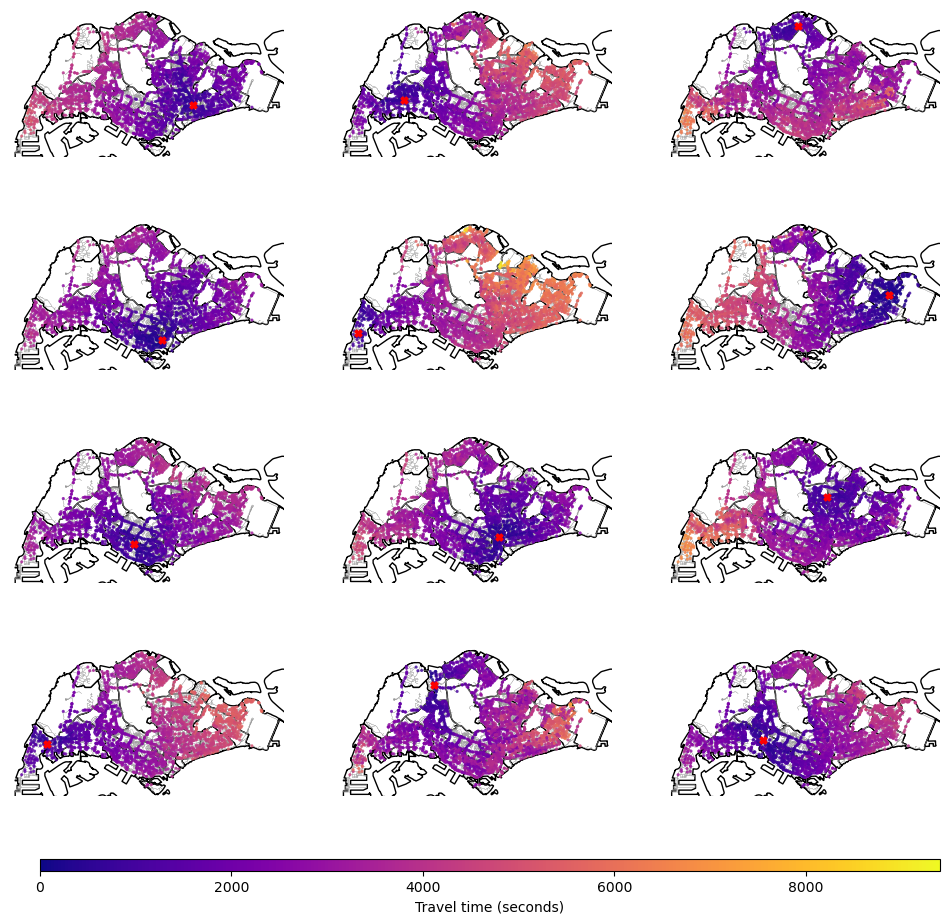

In [68]:
iso_dir = os.path.join(r"data","isochrones")
if not os.path.exists(iso_dir):
    os.mkdir(iso_dir)
n_clusters = len(workplace_cluster.index)
ncols = 3
nrows = n_clusters//ncols
# define cbar 
cbar = plot_utils.get_colorbar(vmin=0,vmax=9400,cmap="plasma",plot=False)
fig, axes = plt.subplots(nrows, ncols, figsize = (ncols*4,nrows*3))
for i, ax in enumerate(axes.flatten()):
    # plot planning area boundary
    planningArea_shp.plot(fc='white',ec='k',ax=ax)
    # get attributes
    lat = workplace_cluster.loc[i,"latitude"]
    lon = workplace_cluster.loc[i,"longitude"]
    node_id = workplace_cluster.loc[i,"node_ID"]
    # extract itinerary based on work place node_id
    itinerary_df = itinerary_df_list[node_id]
    # remove itineraries where there are no bus routes
    itinerary_df = itinerary_df[itinerary_df['number_of_busroutes']>0]
    # plot isochrone
    plot_shortest_path_publicTransit(G_bus, itinerary_df,cbar=cbar,ax=ax)
    # plot orig node
    ax.scatter(lon,lat,marker="X",c="r",s=25)
# plt.tight_layout()
# plot colorbar
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.75, 0.01]) # left, bottom, width, height
fig.colorbar(cbar, cax=cbar_ax, orientation='horizontal', label='Travel time (seconds)')
fp_save = os.path.join(iso_dir,"dry_isochrone_publicTransit_workClusters.png")
plt.savefig(fp_save, bbox_inches = 'tight')
plt.show()

TODO: 

#### Raster analysis
- Map raster inundation map over edges in `G_car` and `G_bus`, pixel by pixel (coord by coord), and add the pixel value (i.e. flood depth) as an attribute `flood_depth` to the edges
    - obtain the geographical coordinates of each pixel's centroid (it may be possible that 1 pixel cover multiple roads, so use pixel centroid instead) and their flood depth
    - obtain closest edge (road) based on coords
- Update edges' attributes - `max_speed` and `travel_time` 

#### Vector/point analysis
If there is no raster inundation map, we will just look at the roads that were flooded at these scenarios - 90th, 95th, 99th, and 99.9th percentile for the max 30 mins rainfall
- Use the `precipitation_levels_during_flood_events.csv` to identify all the roads that have been flooded (in recent times e.g. >=2020) for each rainfall type percentile
- identify relevant road edges for each scenario
- Update edges' attributes - `max_speed` and `travel_time` 

**Rerun flood risk analysis for 2014 to 2024**

1. Can we find out which bus sevices are most likely to be impacted?
2. Can we identify the critical road segments that result in the highest time delay?

# Vector impact travel time analysis

### Import historical flood events

In [8]:
historical_floods = pd.read_csv(r"Flood_Weather_Data\precipitation_levels_during_flood_events.csv")
print(historical_floods.dtypes)
historical_floods.head()

flooded_location                  object
responses_found                    int64
matched_location                  object
latitude                         float64
longitude                        float64
closest_weather_stn               object
mean_pr                          float64
daily rainfall total (mm)        float64
highest 30 min rainfall (mm)     float64
highest 60 min rainfall (mm)     float64
highest 120 min rainfall (mm)    float64
drainage_catchment                object
time                              object
dtype: object


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16


### Import historical weather data

In [7]:
imported_data_dir = os.path.join(os.getcwd(),"Flood_Weather_Data")
percentiles, historical_ppt_percentiles = flood_utils.get_historical_ppt_percentiles(fp=os.path.join(imported_data_dir,"historical_weather.csv"),
                                                                         percentiles=[90,95,99,99.9])
print(percentiles)
print(historical_ppt_percentiles)

[90, 95, 99, 99.9]
{'highest 30 min rainfall (mm)': array([13.8, 21.2, 35.6, 51.4]), 'highest 60 min rainfall (mm)': array([17.    , 26.8   , 47.2   , 70.4767]), 'highest 120 min rainfall (mm)': array([19. , 30.2, 55. , 85. ])}


### Identify flooded roads by rain percentile

[(244893860, 244919173, 0),
 (243674568, 243674565, 1),
 (246144661, 5965615376, 0),
 (158067840, 158043992, 0),
 (246144661, 5965615376, 0),
 (2327166266, 2327165477, 0),
 (1500901727, 236726630, 0),
 (5272396521, 236725686, 0),
 (1347476299, 1347475127, 0),
 (1347470909, 1398083464, 0),
 (1363263572, 26778809, 0),
 (2640830874, 7025068757, 0),
 (4627802466, 4600773947, 0),
 (244957774, 310729678, 0),
 (4604597985, 246141182, 0),
 (4593209131, 5268291019, 0),
 (5272396521, 236725686, 0),
 (5683776500, 4722941844, 0),
 (885999224, 885999274, 0),
 (1744512261, 7048624715, 0),
 (230928500, 378004629, 0),
 (3106351967, 3054873766, 0),
 (378625779, 378626010, 0),
 (3106351967, 3054873766, 0),
 (247037926, 247037923, 0),
 (313933717, 313933735, 0),
 (246144675, 246144669, 0),
 (1347475125, 1347475127, 0),
 (245930058, 6649480074, 0),
 (1793588367, 239935401, 0),
 (245930058, 6649480074, 0),
 (246141154, 246141157, 0),
 (2327166266, 2327165477, 0),
 (7168295555, 6591210040, 0),
 (5607188656,

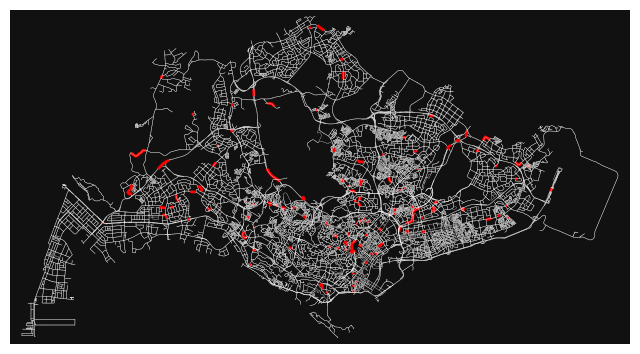

In [ ]:
def identify_flooded_roads(G, historical_floods,rf_value,rf_type='highest 30 min rainfall (mm)', plot = True, ax = None):
    """ 
    identify flooded roads based on historical flooded roads and their associated rainfall value and rainfall type
    Args:
        G (G): driving route
        historical_floods (pd.DataFrame): historical floods from 2014 onwards
        rf_value (float): threshold precipitation value to filter the historical_floods df
        rf_type (str): type of ppt e.g. max 30mins, max 60mins
        plot (bool): if plot is True, plot the identified flooded roads
        ax (mpl.Axes): if None, plot on a new figure, else, plot on supplied ax
    Returns:
        list: list of edges representing flooded roads
    """
    hist_flood_filtered = historical_floods[historical_floods[rf_type]<=rf_value]
    flooded_edges = ox.distance.nearest_edges(G,X = hist_flood_filtered['longitude'], Y = hist_flood_filtered['latitude'])
    flooded_edges = list(flooded_edges)
    if plot:
        ec = ["r" if e in flooded_edges else "white" for e in G.edges(keys=True) ]
        ew = [2 if e in flooded_edges else 0.2 for e in G.edges(keys=True) ]
        fig, ax = ox.plot_graph(
            G,
            node_size=0,
            edge_color = ec,
            edge_linewidth=ew,
            ax=ax,
            show = False,
            close = False
        )
    return flooded_edges

identify_flooded_roads(G_bus,historical_floods,51,rf_type='highest 30 min rainfall (mm)',plot=True)

TODO:
- convert rainfall percentile values to 1 in ? return period of rainfall. We do not have a 1 in ? year of flood event as pluvial flood drain out pretty fast. PUB does have a drainage code of practice that can handle a 1 in 100 year flood.
- for each derived flooded roads for **rainfall value** and **rainfall type**, update the speed and travel time.
- **Determining travel speed during flooding**: sort travel speed bands in `TravelSpeedBands.*.csv` to obtain the lowest speed band during a rainfall event. Select a representative road and obtain the respective speed band e.g. Ang mo kio ave 4 has speed band 2, which corresponds to *10-19km/h*
- Scenarios analysis:
    - speed changes based on flood depth e.g. [Pregnolato et al (2017)](https://www.sciencedirect.com/science/article/pii/S1361920916308367) proposed a depth-disruption function to estimate a relationship between road inundation depth and traffic disruption based on existing empirical studies. *Note*: Only achievable if we have the flood inundation raster map
    - flood depth > 15 - 40 cm, cars stall, road takes 30 - 60 minutes to drain out water. Minimum delay is the delay that it takes for the water to drain away from the road i.e. at most 1 hour.



In [47]:
edges = ox.graph_to_gdfs(G_bus, nodes=False)
edges['maxspeed'] = pd.to_numeric(edges['maxspeed'])
edges['travel_time'].describe()

count    45756.000000
mean         9.119024
std         13.027212
min          0.056037
25%          2.012608
50%          4.707734
75%         11.225749
max        313.808033
Name: travel_time, dtype: float64

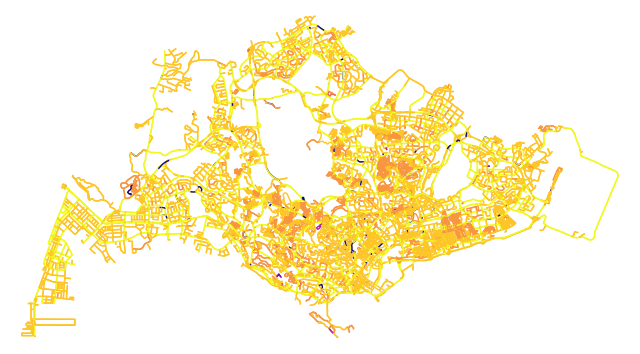

In [57]:
import copy
def update_flooded_road_network(G, flooded_edges, flooded_maxspeed=20, plot=True):
    """ 
    Args:
        G (G): driving network
        flood_edges (list of edges): each item in this list is an edge e.g. (u,v, key)
        flooded_maxspeed (float): max speed on the road when it is flooded. Default is 20 km/h. This will override the maxspeed attribute in G
        plot (bool): If plot is True, visualise the maxspeed on the road
    """
    G_copy = copy.deepcopy(G) # deep copy so it does not change the original
    # convert edges in the graph
    edges = ox.graph_to_gdfs(G_copy, nodes=False)
    # filter edges df by those identified as flooded in flooded_edges, and update the flooded speed
    edges.loc[flooded_edges,'maxspeed'] = flooded_maxspeed
    # case maxspeed column to float64
    edges['maxspeed'] = pd.to_numeric(edges.maxspeed, errors='coerce')
    # update maxspeed in G_copy
    for (_, _, _, data),maxspeed in zip(G_copy.edges(data=True, keys=True),edges['maxspeed']):
        data['maxspeed'] = maxspeed
    # impute speed on all edges missing data
    G_copy = ox.add_edge_speeds(G_copy)
    # calculate travel time (seconds) for all edges
    G_copy = ox.add_edge_travel_times(G_copy)
    # if flooded_maxspeed = 0, update travel time as at most 1 hour because that's the longest it takes for flood waters to drain out
    if plot:
        # visualise the maxspeed
        # sort from lowest to highest max speed
        sorted_maxspeed = edges.sort_values('maxspeed')
        # get unique colours based on unique max speed
        iso_colors = ox.plot.get_colors(n=len(sorted_maxspeed.maxspeed.unique()), cmap="plasma", start=0)
        # map colours according to the sorted maxspeed
        speed_color_map = {speed:col for speed,col in zip(sorted_maxspeed.maxspeed.unique(), iso_colors)}
        # map colours according to the G_copy's road's maxspeed
        ec = [speed_color_map[data['maxspeed']] for _, _, _, data in G_copy.edges(data=True, keys=True)]
        # plot the graph with colored edges
        fig, ax = ox.plot_graph(G_copy, node_size=0, edge_color=ec,bgcolor="white")
    
    # edges = ox.graph_to_gdfs(G_copy, nodes=False)
    return G_copy
    
flooded_edges = identify_flooded_roads(G_bus,historical_floods,51,rf_type='highest 30 min rainfall (mm)',plot=False)
update_flooded_road_network(G_bus, flooded_edges, flooded_maxspeed=5)

In [ ]:
save_dir = os.path.join(os.getcwd(),"data","bus_routing_flood")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
# save error data here
noData_file = os.path.join(r'data','error_itineraryEntry_log2.txt')
# parameter inputs
flooded_maxspeed = int(5)
rf_type = 'highest 30 min rainfall (mm)'
rf_perc = 99.9
rf_map = {perc:rf_val for perc, rf_val in zip(percentiles,list(historical_ppt_percentiles[rf_type]))}
rf_value = rf_map[rf_perc]
flooded_edges = identify_flooded_roads(G_bus,historical_floods,rf_value,rf_type=rf_type,plot=False)
G_bus_flooded = update_flooded_road_network(G_bus, flooded_edges, flooded_maxspeed=flooded_maxspeed,plot=False)

# rerun bus route time with the updated travel time on flooded roads
itinerary_entries = []
for fp in publicTransit_fp_list:
    TI = publicTransit.TripItinerary.from_file(G_bus_flooded, fp=fp)
    try:
        itinerary_entry = TI.get_itinerary_entry()
        itinerary_entries.append(itinerary_entry)
    except:
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{fp}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{fp}\n')

itinerary_df = pd.DataFrame.from_records(itinerary_entries)
# append notes ID to the start and end coordinates
itinerary_df['start_nodesID'] = ox.distance.nearest_nodes(G_bus_flooded,X = itinerary_df['start_lon'], Y = itinerary_df['start_lat'])
itinerary_df['end_nodesID'] = ox.distance.nearest_nodes(G_bus_flooded,X = itinerary_df['end_lon'], Y = itinerary_df['end_lat'])
itinerary_df.to_csv(os.path.join(save_dir,f"bus_routing_rfType{rf_type}_rfPerc{rf_perc}_maxspeed{flooded_maxspeed}.csv"),index=False)
itinerary_df.head()

In [ ]:
def check_itinerary_affected(flooded_edges,itinerary):
    """ 
    Args:
        flood_edges (list of edges): each item in this list is a *set* of nodes in an edge e.g. set([u,v])
        itinerary (dict): json dict of each OD bus itinerary 
    """
    
    for busLeg in itinerary['busLegs']:
        set_busRoute_nodes = set(busLeg['routesNodesID']) # nodes here are all unique
        for e in flooded_edges:
            # check if flooded edge is a subset of set_busRoute_nodes
            if e <= set_busRoute_nodes: 
                # get route time and distance for the flooded edge
                # self.get_route_time_and_distance(list(e))

flooded_edges = identify_flooded_roads(G_bus,historical_floods,51,rf_type='highest 30 min rainfall (mm)',plot=False)
flooded_edges = [set([u,v]) for u,v,_ in flooded_edges]

(25451929, 6749812859, 0)
